## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
number_of_users = df.user_id.nunique()
number_of_users

290584

d. The proportion of users converted.

In [5]:
# none_converted = df.groupby(['converted']).nunique().user_id[0] # Number of none converted users
converted = df.groupby(['converted']).nunique().user_id[1] # Number of converted users
converted_proportion = (converted / number_of_users) * 100  # Get converted users proportion
converted_proportion

12.104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.groupby(['group', 'landing_page']).count()
# count the number where the new_page lineup with the control group
control_newpage = df.query('group == "control" & landing_page == "new_page"').count()[0]

# count the number where the old_page lineup with the treatment group
treatment_oldpage = df.query('group == "treatment" & landing_page == "old_page"').count()[0]

control_newpage + treatment_oldpage

3893

f. Do any of the rows have missing values?

In [7]:
df.duplicated().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# copy the complete dataset to df2

df2 = df.copy() 

# we have 2 lists to delete for the dataset df2

# store the first list in (to_del_1) where we have control and new_page match 

to_del_1 = df2.loc[(df2['group'] == "control") & (df2['landing_page'] == "new_page")].index.tolist()

# store the second list in (to_del_2) where we have treatment and old_page match

to_del_2 = df2.loc[(df2['group'] == "treatment") & (df2['landing_page'] == "old_page")].index.tolist()

# perform the removal of the unwanted lists
df2 = df2.drop(to_del_1)
df2 = df2.drop(to_del_2)

# check the new (df2) size

df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
df2.drop(1899, inplace=True)

In [15]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').count()[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

**The results in the previous two portions are very close and there is no evidence in my opinion that one page will lead to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

**The null hypothesis will be rejected if the conversion rate of the new page is heigher than the conversion rate of the old page:**

$$H_0: p_{old}\ge p_{new}$$$$H_1: p_{old}\lt p_{new}$$

**Alternatively, our Hypothesis test can be:**

$$H_0: p_{new} - p_{old} \le 0$$$$H_1: p_{new} - p_{old} \gt 0$$

**Where $p_{new}$ & $p_{old}$ are the population mean values for new_page and old_page, respectivley.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
#the Null hypothesis states there is not difference between the 
#conversion rates of old and new page. Thus, the whole dataset is used to 
#calculate the convertion rate for the new page (pnew).
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
#the Null hypothesis states there is not difference between the 
#conversion rates of old and new page. Thus, the whole dataset is used to 
#calculate the convertion rate for the old_page (pold).
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
#calculate the number of users landed and new_page
n_new = len(df2.query('landing_page == "new_page"'))

n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
#calculate the number of users landed and new_page
n_old = len(df2.query('landing_page != "new_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1,p_new,n_new)

#new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.11684674144931526

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1,p_old,n_old)

#old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.12004212729049933

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
#since new_page_converted and old_page_converted have different sizes, 
#I use the mean to get the difference
new_page_converted.mean() - old_page_converted.mean()

-0.0031953858411840758

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

**To perform the sampling:**

**3 arrays have beeen created (p_diffs: store the difference , bs_old_means: store the values of the old mean, bs_new_means: store the values of the new mean)**

**For 10000 times, perform the sampling using random.choice and store the difference in means in the p_diffs**

In [27]:
p_diffs, bs_new_means,  bs_old_means  = [], [], []

for i in range(10000):
    bs_new = np.random.choice(2, size=n_new ,p=[p_new,1 - p_new])
    bs_old = np.random.choice(2, size=n_old ,p=[p_old,1 - p_old])
    bs_new_means.append(bs_new.mean())
    bs_old_means.append(bs_old.mean())
    p_diffs.append(bs_new.mean() - bs_old.mean())

In [28]:
np.mean(bs_new_means), np.mean(bs_old_means), np.mean(p_diffs)

(0.8803913839377882, 0.8803954183129811, -4.0343751928110905e-06)

In [29]:
np.std(p_diffs)

0.0012007662055702932

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

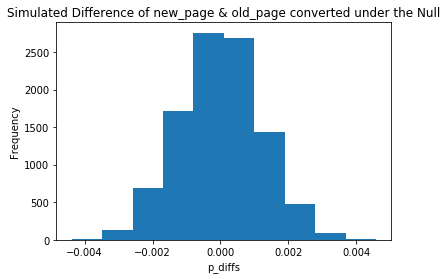

In [30]:
# convert to numpy array
p_diffs = np.array(p_diffs)

# plot sampling distribution
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page & old_page converted under the Null');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

**Obtained the actual difference in means which is stored in actual_diff and marking where the actual difference under the null**

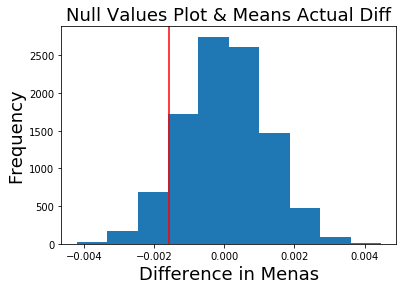

In [31]:
actual_diff = df2.query('landing_page == "new_page"').converted.mean() - df2.query('landing_page == "old_page"').converted.mean()
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(actual_diff, color = "red");
plt.ylabel('Frequency', fontsize = 18);
plt.xlabel('Difference in Menas', fontsize = 18);
plt.title('Null Values Plot & Means Actual Diff', fontsize = 18);

In [32]:
(null_vals > actual_diff).mean()

0.9084

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

**The proprtion where we have p_diffs greater than the actual difference in the population is the p-value. The p-value found was large which suggest that we do not hve evidence to reject the null hypothesis, thus, we should not assume that the new_page is better than the old_page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
convert_old = df2.query('group == "control" & converted == 1')['converted'].count()
convert_new = df2.query('group == "treatment" & converted == 1')['converted'].count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [35]:
# how significant our z-score is
from scipy.stats import norm
norm.cdf(z_score)

0.09494168724097551

In [36]:
#our critical value at 95% confidence is

norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

**The p-value (0.9037) computed in j & k parts is different than the p-value (0.1899) calculated by the z-test method and this is because we did consider from the start that $p_{old}$ and $p_{new}$ are equal which is not the case in the z-test.**

**However, since the z-score (0.905) is less than our critical value at 95% confidence (1.96), we fail to reject the null hypothesis that the difference between the two proportions is no different from zero.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

**Since we have a yes/no or binary type category, Logistic regression is the model that we need to use in this case for regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
#This function will return the value that should be stored in the ab_page column depending on the group data cell for a row
def label_abpage (row):
   if row['group'] == "control" :
      return 0
   elif row['group'] == "treatment" :
      return 1

In [39]:
# create the intercept column
#df2['intercept'] = 1

# create the ab_page column and fill the column data
df2['ab_page'] = df2.apply (lambda row: label_abpage (row),axis=1)
df2['intercept'] = 1

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [40]:
from scipy import stats
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2) # https://github.com/statsmodels/statsmodels/issues/3931


mod = sm.Logit(df2['ab_page'], df2[['converted','intercept']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.693144
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                ab_page   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Aug 2020   Pseudo R-squ.:               4.266e-06
Time:                        17:07:11   Log-Likelihood:            -2.0142e+05
converged:                       True   LL-Null:                   -2.0142e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
converted     -0.0150      0.011     -1.311      0.190      -0.037       0.007
intercept      0.0020      0.004      0.516      0.606      -0.006       0.010
==============================================================================
"""

In [41]:
print(np.exp(res.params))

converted    0.985123
intercept    1.002042
dtype: float64


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**Running [np.exp(res.params)] will give us the odds of coverted which is (0.98). So the odds of conversion is very close to 1 which means that the probability of having someone to convert is almost equal to the probability of not having someone to convert to the new_page. This supports our null hypothesis and there is no evidence that the new_page is better.**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

**Looking at the result of the logit regression model, our intercept $b_0$ is (0.002) and the slope $b_1$ is (-0.015), so ab_page is a function of ($b_0$ + $b_1$ * converted). However, this formual is best applied for Linear regression models. When using the Logistic regression models, we are looking after probability and the odds of the outcome. Running [np.exp(res.params)] will give us the odds of coverted which is (0.98). So the odds of conversion is very close to 1 which means that the probability of having someone to convert is almost equal to the probability of not having someone to convert to the new_page. This supports our null hypothesis and there is no evidence that the new_page is better.**

**The p-value (0.1899) computed by the logistic regression is same as the one calculated by the z-test function. Again both of these p-values are different that the one calculated in j & k parts and this is because we did consider from the start that $p_{old}$ and $p_{new}$ are equal which is not the case in the z-test and the logistic regression model.**

**The p-value (0.1899) is high which supports the failure of rejection to the null hypothesis**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

**Other factors might influence the conversion of indviduals like gender for example. It could be possible that the new_page is more favored by females more than males depening on the design. Moreover, it is important to take into considerations the factors that might affect the conversion rate for any given case. Having additional terms to our model is great as long as they are relevant to the case. More terms can provide more insights and increase/decrease our confidence when either rejecting the null hypothesis or the failure of rejecting the null hypothesis**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

**Reading the countries data and store them into df_countries**

In [42]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [43]:
### Create the necessary dummy variables
df_new[['CA', 'US']] = pd.get_dummies(df_new['country'])[['CA','US']]
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results, and your conclusions based on the results.



In [44]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['CA', 'US', 'intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 21 Aug 2020   Pseudo R-squ.:               2.323e-05
Time:                        17:07:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

**CONCLUSION**

According to the analysis performed I found that the old page was better than the new page, therefore I fail to reject the null hypothesis. Moreover, the histogram shows that the new page is not better than the old page.

From the regression above we see that the p-value is higher in US than in Canada, which means that users in the US are more likely to convert, but still not enough evidence to reject the null hypothesis.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])